In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from zipfile import ZipFile
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm.auto import tqdm
import time
SEED = 42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/Colab Notebooks/data.zip')
data_dir = Path('/content/data')

if data_dir.is_dir():
    print(f"{data_dir} directory already exists")
else:
  data_dir.mkdir(parents=True, exist_ok=True)
  with ZipFile(path, 'r') as zip:
    zip.extractall(data_dir)
    print(f"Unzipped {path} to {data_dir}")


Unzipped /content/drive/MyDrive/Colab Notebooks/data.zip to /content/data


In [ ]:
train_dir = Path('/content/data/data/train')
test_dir = Path('/content/data/data/test')
train_dir, test_dir

(PosixPath('/content/data/data/train'), PosixPath('/content/data/data/test'))

In [ ]:
image_paths = list(train_dir.glob('*/*.jpg'))
len(image_paths)

19996

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

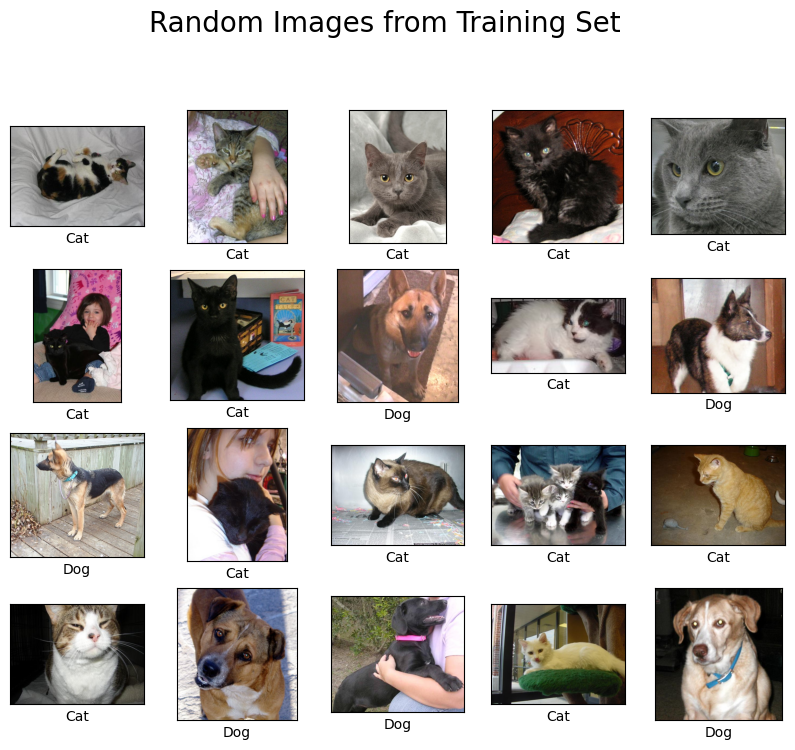

In [ ]:
torch.manual_seed(SEED)
random.seed(SEED)
plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  random_indx = random.randrange(len(image_paths))
  plt.imshow(Image.open(image_paths[random_indx]))
  plt.xlabel(image_paths[random_indx].parent.stem)
  plt.suptitle("Random Images from Training Set",fontsize=20)


In [ ]:
def is_valid_file(filepath):
    try:
        # Try opening the image
        with Image.open(filepath) as img:
            img.verify()  # Checks for image integrity
        return True
    except Exception:
        print(f"Invalid file: {filepath}")
        return False

In [ ]:
#Train Transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),               # Resize to model input size
    transforms.RandomHorizontalFlip(p=0.5),      # Flip left-right (cats/dogs are symmetric)
    transforms.RandomRotation(degrees=15),       # Slight rotation
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),             # Simulate lighting variation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],   # Normalize to [-1, 1]
                         std=[0.5, 0.5, 0.5])
])
#Test Transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [ ]:
torch.manual_seed(SEED)
random.seed(SEED)
train_data = datasets.ImageFolder(root=train_dir,is_valid_file=is_valid_file,transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir,is_valid_file=is_valid_file,transform=test_transform)

Invalid file: /content/data/data/train/Cat/.DS_Store
Invalid file: /content/data/data/train/Cat/Thumbs.db
Invalid file: /content/data/data/train/Dog/.DS_Store


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [ ]:
train_data.class_to_idx

{'Cat': 0, 'Dog': 1}

In [ ]:
torch.manual_seed(SEED)
train_dataloader = DataLoader(dataset=train_data,batch_size=64,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=64,shuffle=False)


In [ ]:
img,label = next(iter(train_dataloader))
img.shape,label.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

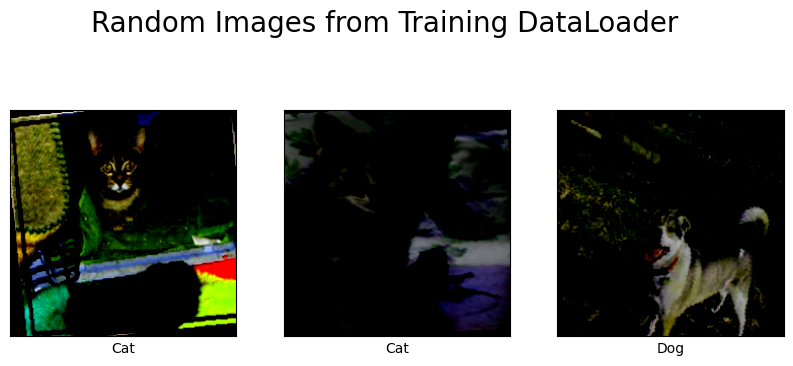

In [ ]:
plt.figure(figsize=(10,10))
for i in range(3):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  random_indx = random.randrange(len(img))
  plt.imshow(img[random_indx].permute(1,2,0))
  plt.xlabel(class_names[label[random_indx]])
  plt.suptitle("Random Images from Training DataLoader",fontsize=20)

In [ ]:
def plot_loss_curves(results,title):
  train_loss = results.get("train_loss")
  train_acc = results.get("train_acc")
  test_loss = results.get("test_loss")
  test_acc = results.get("test_acc")
  epochs = range(len(train_loss))
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,train_loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(epochs,train_acc,label="train_acc")
  plt.plot(epochs,test_acc,label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.suptitle(title,fontsize=20)
  plt.show()

In [ ]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()  # Set model to training mode
    train_loss = 0
    train_acc = 0
    total_samples = 0  # To track total number of samples for accuracy calculation

    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        y_pred = torch.argmax(y_logits, dim=1)
        correct = (y_pred == y).sum().item()
        train_acc += correct
        total_samples += y.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= total_samples

    return train_loss, train_acc

In [ ]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    total_samples = 0
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(dataloader)):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            y_pred = torch.argmax(y_logits, dim=1)
            correct = (y_pred == y).sum().item()
            test_acc += correct
            total_samples += y.size(0)
        test_loss /= len(dataloader)
        test_acc /= total_samples
        return test_loss, test_acc

In [ ]:
def train_test(model,train_dataloader , test_dataloader ,optimizer, loss_fn, epochs, device):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    start_time = time.time()
    torch.manual_seed(SEED)
    random.seed(SEED)
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.4f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.4f}%")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.3f} seconds")
    return results, end_time - start_time

In [ ]:
def convert_seconds(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    print(f"{hours} hour(s), {minutes} minute(s), and {remaining_seconds:.2f} second(s)")


In [ ]:
import torch
import torch.nn as nn

class CatVDogV1(nn.Module):
    def __init__(self, input_shape=3, hidden_units=32, output_shape=2):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),

            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),

            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units*2, hidden_units * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),

            nn.Conv2d(hidden_units * 4, hidden_units * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 4 * 28 * 28, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.conv_block_3(x)
        #print(x.shape)
        x = self.classifier(x)
        return x


In [ ]:
model_1 = CatVDogV1(input_shape=3, hidden_units=32, output_shape=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),lr=0.001)

In [ ]:
model_1_results, model_1_time = train_test(model=model_1,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            epochs=15,
                                            device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1/15 | Train Loss: 1.8180 | Train Acc: 55.8012% | Test Loss: 0.6498 | Test Acc: 66.0736%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2/15 | Train Loss: 0.6791 | Train Acc: 61.9924% | Test Loss: 0.5800 | Test Acc: 69.9120%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3/15 | Train Loss: 0.6198 | Train Acc: 66.6183% | Test Loss: 0.5647 | Test Acc: 71.3715%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4/15 | Train Loss: 0.5790 | Train Acc: 70.0590% | Test Loss: 0.5744 | Test Acc: 71.4914%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5/15 | Train Loss: 0.5620 | Train Acc: 70.7892% | Test Loss: 0.5432 | Test Acc: 72.0512%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6/15 | Train Loss: 0.5373 | Train Acc: 72.8246% | Test Loss: 0.5275 | Test Acc: 73.9304%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7/15 | Train Loss: 0.5124 | Train Acc: 74.7149% | Test Loss: 0.4613 | Test Acc: 77.5690%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8/15 | Train Loss: 0.4984 | Train Acc: 75.3701% | Test Loss: 0.4546 | Test Acc: 78.1687%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9/15 | Train Loss: 0.4637 | Train Acc: 78.0956% | Test Loss: 0.4118 | Test Acc: 81.2675%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10/15 | Train Loss: 0.4390 | Train Acc: 79.6759% | Test Loss: 0.3818 | Test Acc: 83.0268%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 11/15 | Train Loss: 0.4226 | Train Acc: 80.7612% | Test Loss: 0.3690 | Test Acc: 83.3267%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 12/15 | Train Loss: 0.3941 | Train Acc: 82.4015% | Test Loss: 0.3864 | Test Acc: 84.5262%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 13/15 | Train Loss: 0.3654 | Train Acc: 84.2168% | Test Loss: 0.3302 | Test Acc: 86.4254%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 14/15 | Train Loss: 0.3489 | Train Acc: 84.8220% | Test Loss: 0.4070 | Test Acc: 82.5870%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 15/15 | Train Loss: 0.3367 | Train Acc: 85.4171% | Test Loss: 0.2964 | Test Acc: 87.4650%
Total training time: 4236.283 seconds


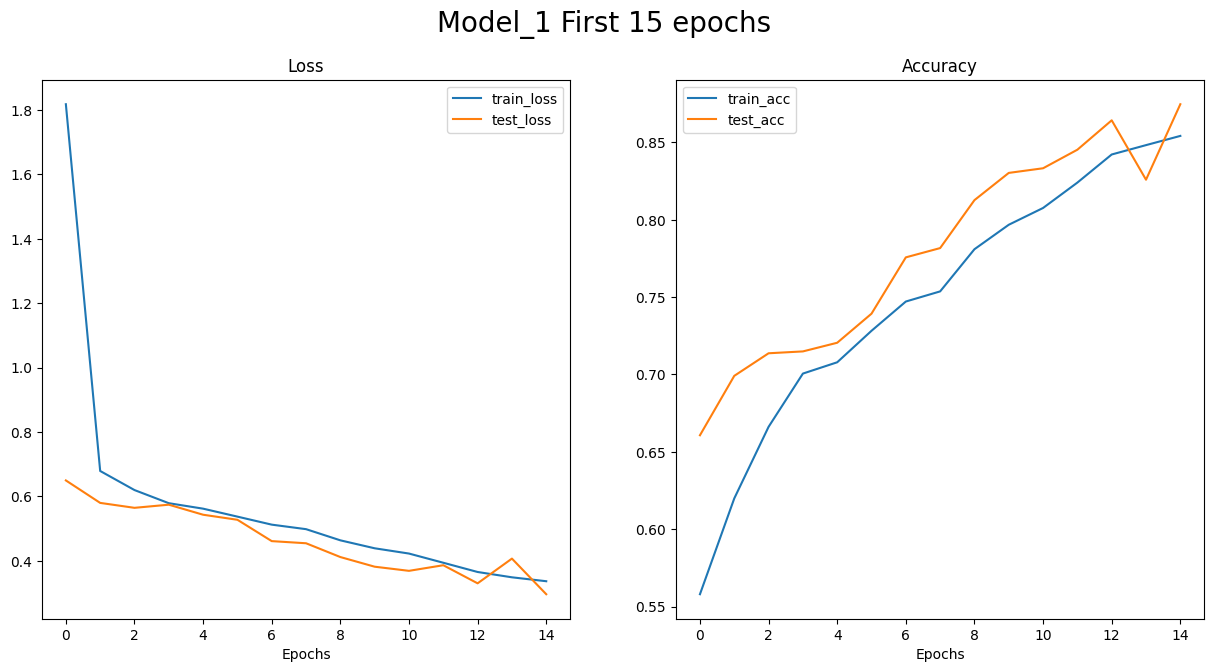

In [ ]:
plot_loss_curves(model_1_results,"Model_1 First 15 epochs")

In [ ]:
torch.save(model_1.state_dict(), 'model_2_v1.pth')

In [ ]:
model_1_results_2, model_1_time_2 = train_test(model=model_1,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            epochs=5,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1/5 | Train Loss: 0.3100 | Train Acc: 86.8024% | Test Loss: 0.3461 | Test Acc: 86.3055%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2/5 | Train Loss: 0.2876 | Train Acc: 88.0626% | Test Loss: 0.3241 | Test Acc: 87.7049%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3/5 | Train Loss: 0.2749 | Train Acc: 88.4327% | Test Loss: 0.2543 | Test Acc: 90.0040%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4/5 | Train Loss: 0.2631 | Train Acc: 89.1878% | Test Loss: 0.2465 | Test Acc: 89.7041%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5/5 | Train Loss: 0.2445 | Train Acc: 89.8580% | Test Loss: 0.2398 | Test Acc: 89.9440%
Total training time: 1421.705 seconds


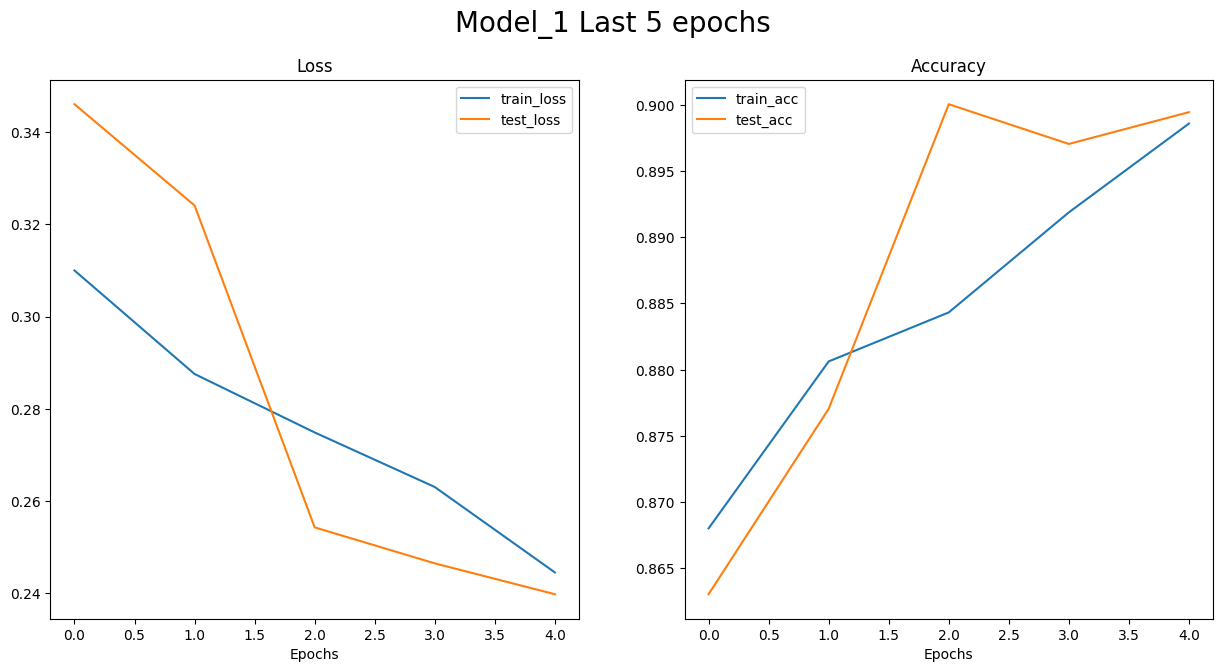

In [ ]:
plot_loss_curves(model_1_results_2,"Model_1 Last 5 epochs")

In [ ]:
torch.save(model_1.state_dict(), 'model_2_v2.pth')

In [ ]:
model_1_results_3, model_1_time_3 = train_test(model=model_1,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            epochs=5,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1/5 | Train Loss: 0.2229 | Train Acc: 90.9182% | Test Loss: 0.2166 | Test Acc: 91.1036%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2/5 | Train Loss: 0.2085 | Train Acc: 91.6233% | Test Loss: 0.2423 | Test Acc: 91.0436%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3/5 | Train Loss: 0.2009 | Train Acc: 91.9484% | Test Loss: 0.1955 | Test Acc: 92.5430%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4/5 | Train Loss: 0.1924 | Train Acc: 92.3335% | Test Loss: 0.3131 | Test Acc: 87.6250%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5/5 | Train Loss: 0.1797 | Train Acc: 92.9186% | Test Loss: 0.1975 | Test Acc: 91.9032%
Total training time: 1436.723 seconds


In [ ]:
torch.save(model_1.state_dict(), 'model_2_v3.pth')

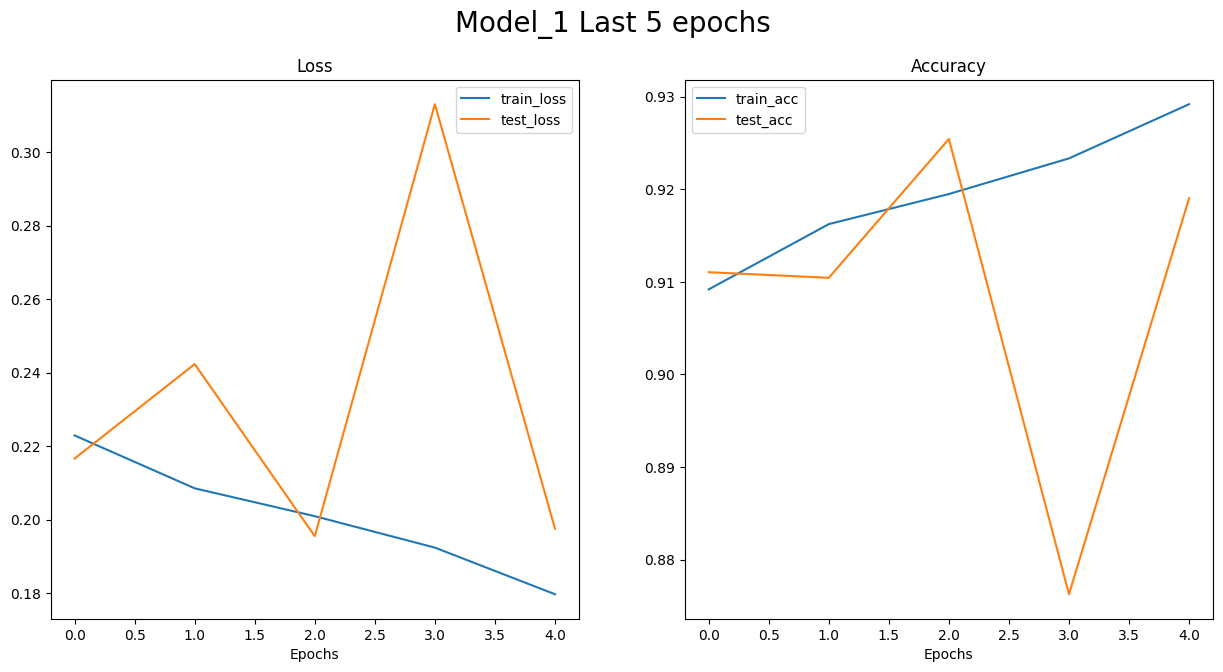

In [ ]:
plot_loss_curves(model_1_results_3,"Model_1 Last 5 epochs")

In [ ]:
model_1_results_4, model_1_time_4 = train_test(model=model_1,
                                            train_dataloader=train_dataloader,
                                            test_dataloader=test_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            epochs=5,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch: 1/5 | Train Loss: 0.1657 | Train Acc: 93.4637% | Test Loss: 0.1957 | Test Acc: 92.1032%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2/5 | Train Loss: 0.1530 | Train Acc: 93.9838% | Test Loss: 0.2077 | Test Acc: 92.5430%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3/5 | Train Loss: 0.1555 | Train Acc: 93.7638% | Test Loss: 0.1722 | Test Acc: 93.1228%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4/5 | Train Loss: 0.1405 | Train Acc: 94.3689% | Test Loss: 0.2612 | Test Acc: 90.9836%


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5/5 | Train Loss: 0.1419 | Train Acc: 94.4189% | Test Loss: 0.2023 | Test Acc: 92.2431%
Total training time: 1417.345 seconds


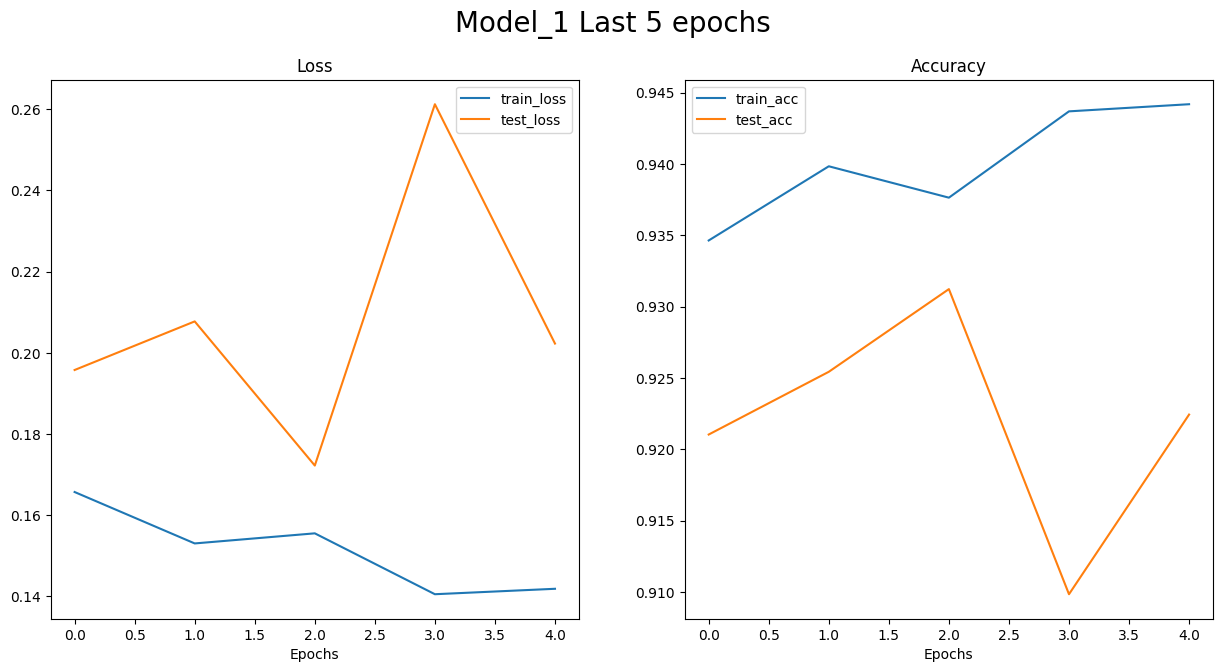

In [ ]:
plot_loss_curves(model_1_results_4,"Model_1 Last 5 epochs")

In [ ]:
torch.save(model_1.state_dict(), 'model_2_v4.pth')